# POLI 175 - Lecture 22

## Support Vector Machines II

# Support Vector Machines

## Support Vector Machines

- Today let's talk about how to estimate SVMs to data using `scikit learn`

- We will also learn a few more things about `sklearn` to use it like a pro.

- Let's get started:

In [31]:
## Loading the relevant packages
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at our friend here to help with GAM
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# Loading scikit learn relevant packages (note our new friends!)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, mean_squared_error, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import VotingClassifier, BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

## Support Vector Machines

- If you recall from the previous class:
    1. If we have perfect separation, we can use the Maximal Margin Classifier
    2. Since this is usually not the case, we can use the Support Vector Classifiers (allows for a bit of misclassification to happen)
    3. Since this only produces a linear decision boundary, we expand by changing the Euclidean inner product to a kernel estimator shaped to improve the classification.
    
- On our end, we will fit the second and the third cases since the first one needs a very particular structure: a separable classification problem.

## Support Vector Machines

- Let us use SVM to classify the vote for Pinochet.

In [2]:
## Loading Chile data
chile = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/chilesurvey.csv')
chile_clean = chile.dropna()
chile_clean = chile_clean[chile_clean['vote'].isin(['Y', 'N'])]
chile_clean['vote'] = np.where(chile_clean['vote'] == 'Y', 1, 0)
chile_clean['logincome'] = np.log(chile_clean['income'])
chile_clean['logpop'] = np.log(chile_clean['population'])
dummies = pd.get_dummies(chile_clean['sex'], prefix = 'sex', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['region'], prefix = 'region', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['education'], prefix = 'education', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
chile_clean.head()

,region,population,sex,age,education,income,statusquo,vote,logincome,logpop,sex_M,region_M,region_N,region_S,region_SA,education_PS,education_S
0,N,175000,M,65.0,P,35000.0,1.00820,1,10.463103,12.072541,1,0,1,0,0,0,0
1,N,175000,M,29.0,PS,7500.0,-1.29617,0,8.922658,12.072541,1,0,1,0,0,1,0
2,N,175000,F,38.0,P,15000.0,1.23072,1,9.615805,12.072541,0,0,1,0,0,0,0
3,N,175000,F,49.0,P,35000.0,-1.03163,0,10.463103,12.072541,0,0,1,0,0,0,0
4,N,175000,F,23.0,S,35000.0,-1.10496,0,10.463103,12.072541,0,0,1,0,0,0,1


In [33]:
## Loading Chile data
y = chile_clean['vote']
X = chile_clean[['age', 'statusquo']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 12345)

In [34]:
## Linear SVM (Support Vector Classifier)
svc = SVC(kernel = 'linear').fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[249  11]
 [ 21 230]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       260
           1       0.95      0.92      0.93       251

    accuracy                           0.94       511
   macro avg       0.94      0.94      0.94       511
weighted avg       0.94      0.94      0.94       511



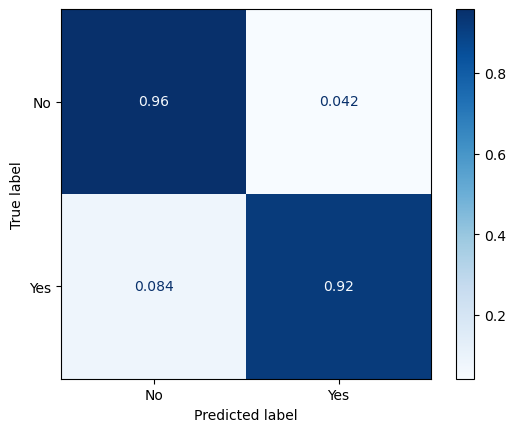

In [37]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

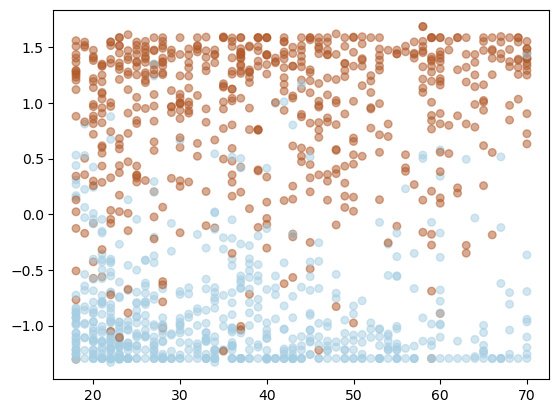

In [38]:
# Plot data
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 30, alpha = 0.5, cmap = plt.cm.Paired)
plt.show()

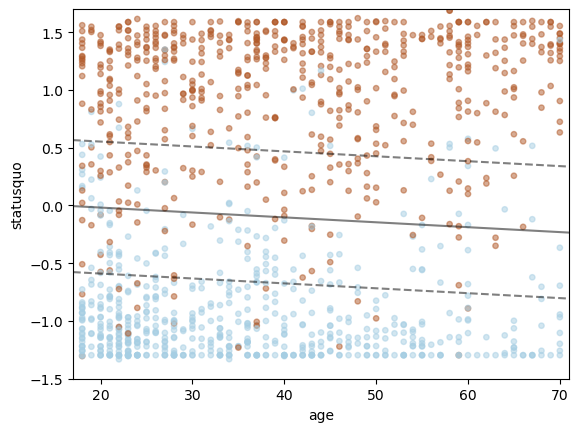

In [7]:
# Decision Function
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap = plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

plt.ylim(-1.5, 1.7)
plt.show()

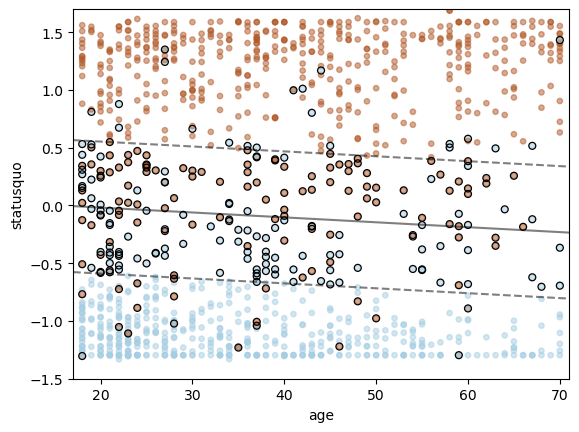

In [8]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(svc,
    X_train,plot_method = "contour",
    colors = "k",levels = [-1, 0, 1],
    alpha = 0.5,linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],s = 25,
    linewidth = 0.9,facecolors = "none",
    edgecolors = "k",alpha = 1)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

**Your turn**: Add all the variables to your classifier. You will lose the decision boundaries viz but probably have a better prediction. Is that the case?

In [9]:
## Your answers here

## Support Vector Machines

- How do we optimize these results?

- There are many ways to improve here. 

Let us learn how to check the default parameters.

In [10]:
# Find parameters
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Support Vector Machines

- We usually focus on $C$.

- Here, we will use GridSearch to find the best $C$.

In [39]:
# Cs
Cs = np.logspace(0, 2, 50)
print(Cs)

[  1.           1.09854114   1.20679264   1.32571137   1.45634848
   1.59985872   1.75751062   1.93069773   2.12095089   2.32995181
   2.55954792   2.8117687    3.0888436    3.39322177   3.72759372
   4.09491506   4.49843267   4.94171336   5.42867544   5.96362332
   6.55128557   7.19685673   7.90604321   8.68511374   9.54095476
  10.48113134  11.51395399  12.64855217  13.89495494  15.26417967
  16.76832937  18.42069969  20.23589648  22.22996483  24.42053095
  26.82695795  29.47051703  32.37457543  35.56480306  39.06939937
  42.9193426   47.14866363  51.79474679  56.89866029  62.50551925
  68.6648845   75.43120063  82.86427729  91.0298178  100.        ]


In [40]:
## Choosing the best C
# Model
svc = SVC(kernel = 'linear')

# Parameters for gridsearch
param_grid = {'C': Cs}

# Build the GridSearch
search = GridSearchCV(svc, param_grid, n_jobs = -1)
search.fit(X_train, y_train)

# Results
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

## Using the best parameters
svc = search.best_estimator_
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameter (CV score=0.919):
{'C': 62.505519252739695}
[[249  11]
 [ 21 230]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       260
           1       0.95      0.92      0.93       251

    accuracy                           0.94       511
   macro avg       0.94      0.94      0.94       511
weighted avg       0.94      0.94      0.94       511



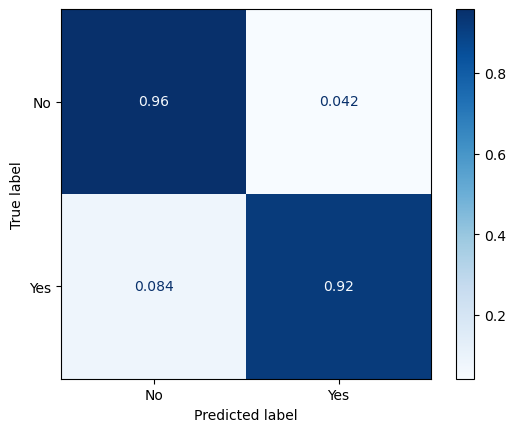

In [13]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

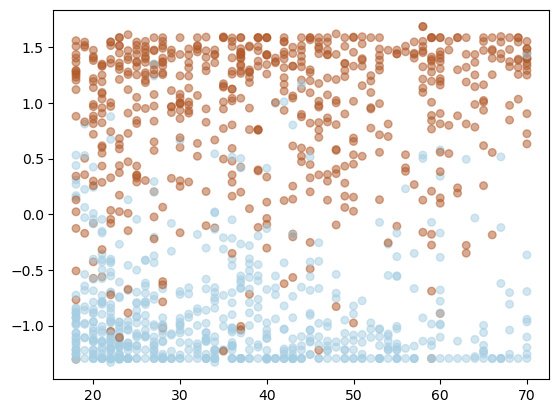

In [14]:
# Plot data
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 30, alpha = 0.5, cmap = plt.cm.Paired)
plt.show()

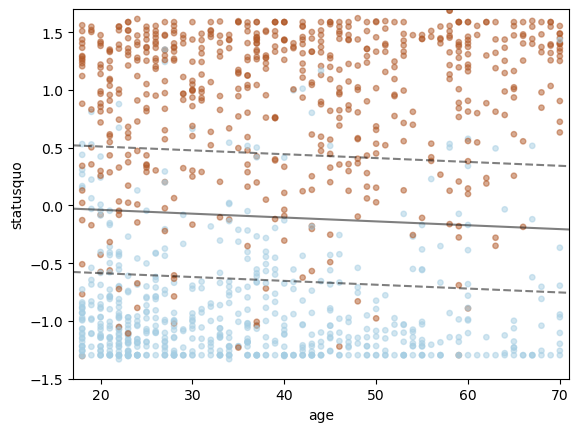

In [15]:
# Decision Function
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap = plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

plt.ylim(-1.5, 1.7)
plt.show()

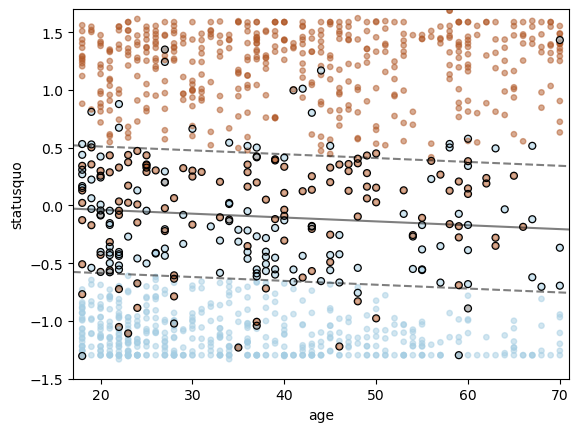

In [16]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

- Now, let us change the `kernel`. We will start with a polynomial kernel to warm up.

In [17]:
## Polynomial SVM (Support Vector Classifier) ## btw: default is cubic
svc = SVC(kernel = 'poly').fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[253   7]
 [ 70 181]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       260
           1       0.96      0.72      0.82       251

    accuracy                           0.85       511
   macro avg       0.87      0.85      0.85       511
weighted avg       0.87      0.85      0.85       511



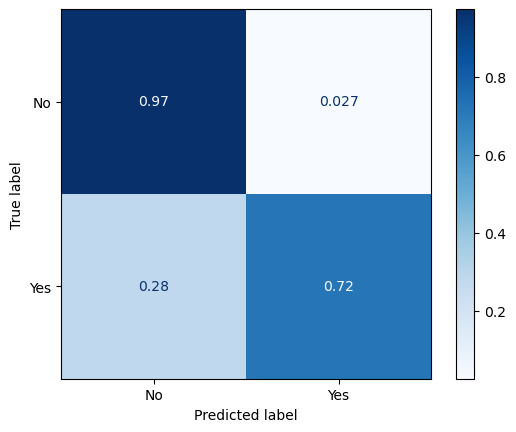

In [18]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

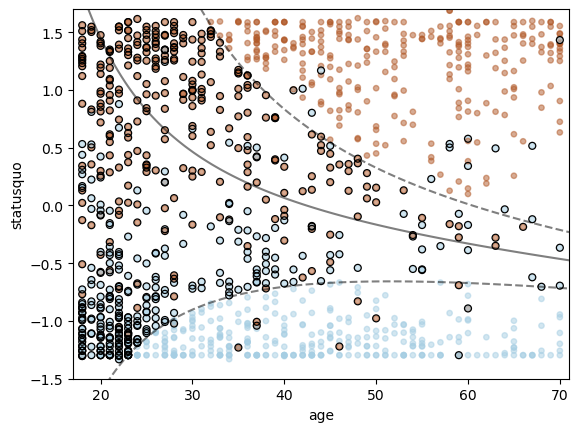

In [19]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

**Your turn:** Use cross-validation to change your polynomial degree, from 1 (linear) to 5. What degree do you do best?

Hint: Use the `get_params()` method.

In [20]:
# Poly degree
dge = np.arange(1, 6)
print(dge)
## Your answers here

[1 2 3 4 5]


## Support Vector Machines

- Now, let us improve our model by use GridSearchCV to find the best $C$ and $degree$ for our problem.

In [21]:
## Choosing the best C
Cs = np.logspace(0, 2, 25)
dge = np.arange(1, 6)

# Model
svc = SVC(kernel = 'poly')

# Parameters for gridsearch
param_grid = {
    'C': Cs,
    'degree': dge
}

# Build the GridSearch
search = GridSearchCV(svc, param_grid, n_jobs = -1)
search.fit(X_train, y_train)

# Results
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

## Using the best parameters
svc = search.best_estimator_
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameter (CV score=0.921):
{'C': 5.623413251903491, 'degree': 2}
[[249  11]
 [ 24 227]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       260
           1       0.95      0.90      0.93       251

    accuracy                           0.93       511
   macro avg       0.93      0.93      0.93       511
weighted avg       0.93      0.93      0.93       511



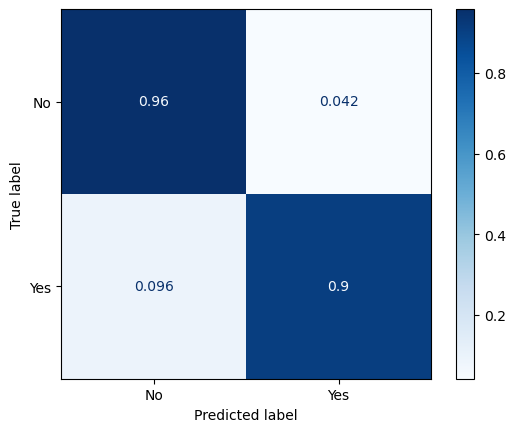

In [22]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

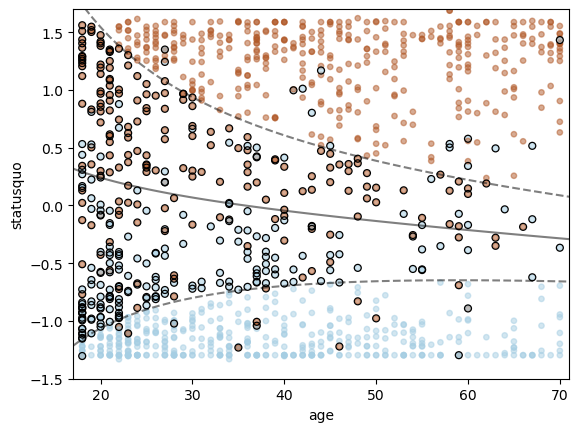

In [23]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

- Now, let us use the radial kernel (the circle thingy from the previous class).

In [24]:
## Choosing the best C and gammas
Cs = np.logspace(0, 2, 25)
gammas = np.logspace(-1, 1, 25)

# Model (Radial Kernel)
svc = SVC(kernel = 'rbf')

# Parameters for gridsearch
param_grid = {
    'C': Cs,
    'gamma': gammas
}

# Build the GridSearch
search = GridSearchCV(svc, param_grid, n_jobs = -1)
search.fit(X_train, y_train)

# Results
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

## Using the best parameters
svc = search.best_estimator_
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameter (CV score=0.922):
{'C': 56.23413251903491, 'gamma': 0.1}
[[245  15]
 [ 28 223]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       260
           1       0.94      0.89      0.91       251

    accuracy                           0.92       511
   macro avg       0.92      0.92      0.92       511
weighted avg       0.92      0.92      0.92       511



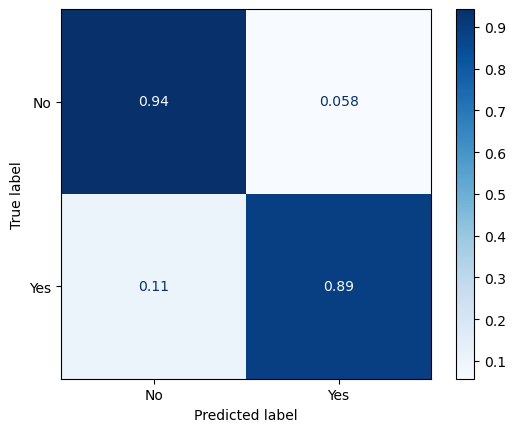

In [25]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        display_labels = ['No', 'Yes'],
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

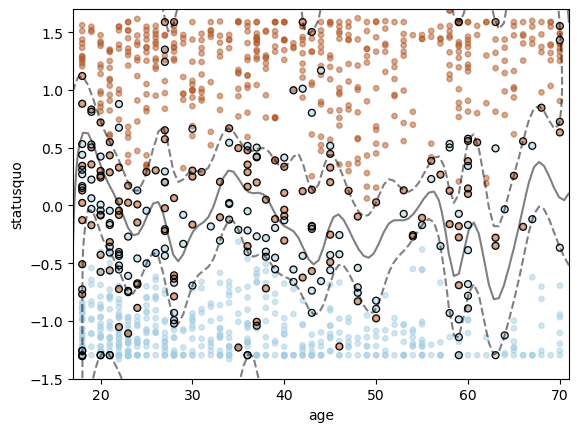

In [26]:
# Decision Function with Support Vectors
plt.scatter(X_train.age, X_train.statusquo, c = y_train, s = 15, cmap=plt.cm.Paired, alpha = 0.5)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svc,
    X_train,
    plot_method = "contour",
    colors = "k",
    levels = [-1, 0, 1],
    alpha = 0.5,
    linestyles = ["--", "-", "--"],
    ax = ax)

ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s = 25,
    linewidth = 0.9,
    facecolors = "none",
    edgecolors = "k",
    alpha = 1
)

plt.ylim(-1.5, 1.7)
plt.show()

## Support Vector Machines

- Now let us do some multiclass classification: Note that the survey answer was: Yes, No, Unsure, and Abstein.

- Can we predict these classes using SVMs? Yes! Let us see how it does?!

In [27]:
## Loading Chile data
chile_clean2 = chile.dropna()
chile_clean2['logincome'] = np.log(chile_clean2['income'])
chile_clean2['logpop'] = np.log(chile_clean2['population'])
dummies = pd.get_dummies(chile_clean2['sex'], prefix = 'sex', drop_first = True)
chile_clean2 = pd.concat([chile_clean2, dummies], axis=1)
dummies = pd.get_dummies(chile_clean2['region'], prefix = 'region', drop_first = True)
chile_clean2 = pd.concat([chile_clean2, dummies], axis=1)
dummies = pd.get_dummies(chile_clean2['education'], prefix = 'education', drop_first = True)
chile_clean2 = pd.concat([chile_clean2, dummies], axis=1)
print(chile_clean2.vote.value_counts())
## Loading Chile data
y = chile_clean2['vote']
X = chile_clean2[['age', 'statusquo', 'logincome', 'logpop', 'sex_M', 
                  'region_M', 'region_N', 'region_S', 'region_SA', 'education_PS', 'education_S']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 12345)
chile_clean2.head()

N    867
Y    836
U    551
A    177
Name: vote, dtype: int64


/var/folders/57/5cl1vf6549d34n3t9xpfz0fr0000gn/T/ipykernel_73097/2089051620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chile_clean2['logincome'] = np.log(chile_clean2['income'])
/var/folders/57/5cl1vf6549d34n3t9xpfz0fr0000gn/T/ipykernel_73097/2089051620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chile_clean2['logpop'] = np.log(chile_clean2['population'])


,region,population,sex,age,education,income,statusquo,vote,logincome,logpop,sex_M,region_M,region_N,region_S,region_SA,education_PS,education_S
0,N,175000,M,65.0,P,35000.0,1.00820,Y,10.463103,12.072541,1,0,1,0,0,0,0
1,N,175000,M,29.0,PS,7500.0,-1.29617,N,8.922658,12.072541,1,0,1,0,0,1,0
2,N,175000,F,38.0,P,15000.0,1.23072,Y,9.615805,12.072541,0,0,1,0,0,0,0
3,N,175000,F,49.0,P,35000.0,-1.03163,N,10.463103,12.072541,0,0,1,0,0,0,0
4,N,175000,F,23.0,S,35000.0,-1.10496,N,10.463103,12.072541,0,0,1,0,0,0,1


In [28]:
## Linear SVM (Support Vector Classifier)
svc = SVC(kernel = 'rbf', gamma = 1).fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  1  21   8  23]
 [  1 202  20  37]
 [  3  59  23  81]
 [  1  21  27 202]]
              precision    recall  f1-score   support

           A       0.17      0.02      0.03        53
           N       0.67      0.78      0.72       260
           U       0.29      0.14      0.19       166
           Y       0.59      0.80      0.68       251

    accuracy                           0.59       730
   macro avg       0.43      0.43      0.41       730
weighted avg       0.52      0.59      0.53       730



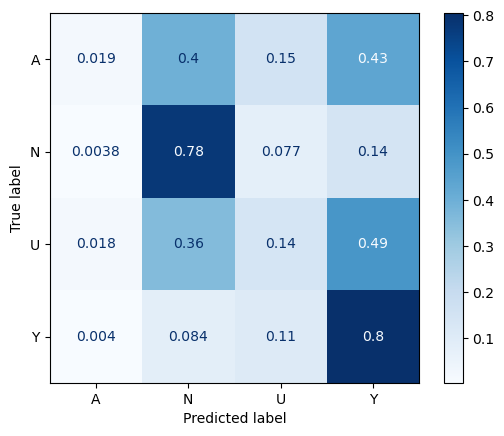

In [29]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
        cmap = plt.cm.Blues, normalize = 'true')
plt.show()

## Support Vector Machines

- This is pretty much it.

- There is something called [Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), if you want to see the extension to this method to regression.

- Suggestion: Try this technique with the civil conflict dataset. And don't forget to rescale the variables.

# Questions?

# See you next class
